# Reconhecimento de Padrões (TIP8311) - Trabalho 1


**Professor:** Guilherme de Alencar Barreto  

<img src="https://loop.frontiersin.org/images/profile/243428/203" alt="Foto do Professor" width="150"/>


**Aluno:** Luis Felipe Carneiro de Souza    **Matrícula:** 593034

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from pathlib import Path

Caminho para salvar gráficos

In [91]:
BASE = Path("..").resolve()
graficos = BASE / "trabalho-1" / "graficos"

Modelos utilizados

In [31]:
class KNN:
    def __init__(self, k=1, m=2):
        self.X_train = None
        self.y_train = None
        self.k = k
        self.m = m

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):

        n_test = len(X)
        n_train = len(self.X_train)
        y_pred = []

        for i in range(n_test):

            dist = []

            for j in range(n_train):

                diff = np.abs(X[i, :] - self.X_train[j , :])
                dist.append(np.sum(diff ** (self.m)))

            dist = np.array(dist)
            idx = np.argsort(dist)[:self.k]
            neighbors, count = np.unique(self.y_train[idx], return_counts=True)
            y_pred.append(neighbors[np.argmax(count)])

        return np.array(y_pred).ravel()
        

In [5]:
class DMC:
    def __init__(self):
        self.centroides = None
        self.classes = None

    def fit(self, X, y):

        self.classes = np.sort(np.unique(y))
        self.centroides = []

        for c in self.classes:

            mask = (y == c)
            self.centroides.append(X[mask].mean(axis=0))

        self.centroides = np.array(self.centroides)

    def predict(self, X):

        n_test = len(X)
        y_pred = []

        for i in range(n_test):

            dist = []

            for c in self.centroides:

                diff = np.abs(c - X[i, :])
                dist.append(np.sum(diff ** 2))

            dist = np.array(dist)
            y_pred.append(self.classes[np.argmin(dist)])

        return np.array(y_pred).ravel()

In [32]:
class DMCR:
    def __init__(self):
        self.centroides = None
        self.classes = None

    def fit(self, X, y):

        self.classes = np.sort(np.unique(y))
        self.centroides = []

        for c in self.classes:

            mask = (y == c)
            self.centroides.append(np.median(X[mask], axis=0))

        self.centroides = np.array(self.centroides)

    def predict(self, X):

        n_test = len(X)
        y_pred = []

        for i in range(n_test):

            dist = []

            for c in self.centroides:

                diff = np.abs(c - X[i, :])
                dist.append(np.sum(diff))

            dist = np.array(dist)
            y_pred.append(self.classes[np.argmin(dist)])

        return np.array(y_pred).ravel()

In [33]:
class MaxCorr:
    def __init__(self):
        self.centroides = None
        self.classes = None

    def fit(self, X, y):

        self.classes = np.sort(np.unique(y))
        self.centroides = []

        for c in self.classes:

            mask = (y == c)
            self.centroides.append(X[mask].mean(axis=0))

        self.centroides = np.array(self.centroides)

    def predict(self, X):

        n_test = len(X)
        y_pred = []

        for i in range(n_test):

            corr_array = []

            for c in self.centroides:

                corr = np.dot(c, X[i, :])
                corr_array.append(corr)

            corr_array = np.array(corr_array)
            y_pred.append(self.classes[np.argmax(corr_array)])

        return np.array(y_pred).ravel()

In [8]:
class StandardScaler:
    def __init__(self):
        self.X_mu = None
        self.X_sigma = None
        self.y_mu = None
        self.y_sigma = None

    def fit(self, X, y=None):
        self.X_mu = np.mean(X, axis=0)
        self.X_sigma = np.std(X, axis=0)
        self.X_sigma = np.where(self.X_sigma == 0, 1.0, self.X_sigma)

        if y is not None:
            self.y_mu = np.mean(y, axis=0)
            self.y_sigma = np.std(y, axis=0)

    def transform(self, X, y=None):
        
        X_scaled = (X - self.X_mu) / self.X_sigma

        if y is not None:
            y_scaled = (y - self.y_mu) / self.y_sigma

        if y is None:
            return X_scaled
        else:
            return X_scaled, y_scaled

In [9]:
class MinMaxScaler:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass

    def predict(self, X, y=None):
        pass

In [10]:
def accuracy_score(y_true, y_pred):
    return float(np.mean(y_true == y_pred))

In [11]:
def confusion_matrix(y_true, y_pred, classes):
    
    n_classes = len(classes)
    
    matriz = np.zeros((n_classes, n_classes), dtype=int)
    
    mapa_indices = {label: i for i, label in enumerate(classes)}
    
    for real, predito in zip(y_true, y_pred):
    
        linha = mapa_indices[real]
        coluna = mapa_indices[predito]
        
        matriz[linha, coluna] += 1
        
    return matriz

Funções auxiliares para as análises

In [19]:
def avaliacao(nome_modelo, modelo, X, y, test_size, n_rodadas=100):
    time_train = []
    time_test = []
    acuracias = []

    melhor_acc = -1
    pior_acc = float('inf')
    melhor_cm = None
    pior_cm = None

    classes = np.sort(np.unique(y))
    acc_p_classe = {c: [] for c in classes}

    for _ in tqdm(range(n_rodadas)):

        idx = np.random.permutation(X.shape[0])
        X, y = X[idx], y[idx]

        split = int((1 - test_size) * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Treinamento
        t0 = time()
        modelo.fit(X_train_scaled, y_train)
        time_train.append(time() - t0)

        # Predição
        t0 = time()
        y_pred = modelo.predict(X_test_scaled)
        time_test.append(time() - t0)

        acc = accuracy_score(y_test, y_pred)
        acuracias.append(acc)

        cm = confusion_matrix(y_test, y_pred, classes)

        diagonais = cm.diagonal()
        totais_linha = cm.sum(axis=1)
        for i, c in enumerate(classes):
            if totais_linha[i] > 0:
                acc_p_classe[c].append(diagonais[i] / totais_linha[i])

        if acc > melhor_acc:
            melhor_acc = acc
            melhor_cm = cm
        if acc < pior_acc:
            pior_acc = acc
            pior_cm = cm

        resultados = {
            'modelo': nome_modelo,
            'test_size': test_size,
            'tempo_treino_medio': np.mean(time_train),
            'tempo_teste_medio': np.mean(time_test),
            'acc_media': np.mean(acuracias),
            'acc_std': np.std(acuracias),
            'acc_max': np.max(acuracias),
            'acc_min': np.min(acuracias),
            'acc_mediana': np.median(acuracias),
            'melhor_cm': melhor_cm,
            'pior_cm': pior_cm,
            'acc_por_classe': {c: np.mean(acc_p_classe[c]) for c in classes}
        }
    return resultados 

In [55]:
def exibir_resultados(res):
    print(f"\n{'='*50}")
    print(f"Modelo: {res['modelo']} | Separação (Treino/Teste): {int((1-res['test_size'])*100)}/{int(res['test_size']*100)}")
    print(f"{'='*50}")
    print(f"Tempo Médio Treino: {res['tempo_treino_medio']:.6f}s | Tempo Médio Teste: {res['tempo_teste_medio']:.6f}s")
    print(f"Acurácia Média:   {res['acc_media']:.4f} ± {res['acc_std']:.4f}")
    print(f"Acurácia Máxima:  {res['acc_max']:.4f}")
    print(f"Acurácia Mínima:  {res['acc_min']:.4f}")
    print(f"Acurácia Mediana: {res['acc_mediana']:.4f}")
    print(f"\nAcurácia Média por Classe:")
    for c, acc in res['acc_por_classe'].items():
        print(f"  - {c}: {acc:.4f}")
    print(f"\nMelhor Matriz de Confusão:\n{res['melhor_cm']}")
    print(f"\nPior Matriz de Confusão:\n{res['pior_cm']}")

In [ ]:
def plotar_todas_acuracias(resultados_por_modelo):
    """
    Plota a evolução da acurácia de TODOS os modelos no mesmo gráfico de linhas.
    """
    plt.figure(figsize=(12, 7))
    
    # Marcadores diferentes para diferenciar melhor as linhas
    marcadores = ['o', 's', '^', 'v', 'D', 'p', '*', 'X', '>']
    
    for i, (nome, resultados) in enumerate(resultados_por_modelo.items()):
        # Ordena por test_size para a linha não ficar embaralhada
        res_ordenados = sorted(resultados, key=lambda x: x['test_size'])
        
        x_test_sizes = [r['test_size'] * 100 for r in res_ordenados] # Em %
        y_acc = [r['acc_media'] for r in res_ordenados]
        
        plt.plot(x_test_sizes, y_acc, marker=marcadores[i % len(marcadores)], 
                 linewidth=2, markersize=8, label=nome)

    plt.title('Comparativo Geral: Efeito da Separação Treino/Teste na Acurácia', fontsize=14, pad=15)
    plt.xlabel('Porcentagem do Conjunto de Teste (%)', fontsize=12)
    plt.ylabel('Acurácia Média', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Coloca a legenda fora do gráfico para não cobrir as linhas
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(graficos / "acuracias.pdf")
    plt.show()

In [112]:
def plotar_tempos_condensados(resultados_por_modelo, test_size_foco=0.3):
    """
    Cria 2 subplots lado a lado comparando os tempos de Treino e Teste de todos os modelos.
    """
    nomes = list(resultados_por_modelo.keys())
    tempos_treino = []
    tempos_teste = []
    
    for nome in nomes:
        # Busca o resultado específico para a proporção escolhida (ex: 30% teste)
        res_foco = next(r for r in resultados_por_modelo[nome] if r['test_size'] == test_size_foco)
        tempos_treino.append(res_foco['tempo_treino_medio'])
        tempos_teste.append(res_foco['tempo_teste_medio'])

    # Cria a figura com 2 subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico 1: Treino
    ax1.barh(nomes, tempos_treino, color='#55A868', edgecolor='black')
    ax1.set_title(f'Tempo de Treinamento (Teste: {int(test_size_foco*100)}%)', fontsize=12)
    ax1.set_xlabel('Segundos')
    ax1.invert_yaxis() # Inverte para o primeiro modelo ficar no topo
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Gráfico 2: Teste
    # Usamos escala logarítmica (opcional) caso o KNN seja absurdamente mais lento que os centróides
    ax2.barh(nomes, tempos_teste, color='#C44E52', edgecolor='black')
    ax2.set_title(f'Tempo de Teste (Teste: {int(test_size_foco*100)}%)', fontsize=12)
    ax2.set_xlabel('Segundos')
    ax2.invert_yaxis()
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(graficos / f"tempos_{('').join(str(test_size_foco).split('.'))}.pdf")
    plt.show()

In [113]:
def plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.3, tipo='melhor_cm'):
    """
    Cria um grid 3x3 com as matrizes de confusão da melhor rodada de cada modelo.
    """
    nomes = list(resultados_por_modelo.keys())
    
    # Cria uma figura 3x3
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten() # Transforma a matriz de eixos num array 1D para facilitar o loop
    
    for i, nome in enumerate(nomes):
        if i >= 9: break # Garante que não vai estourar o limite de 9 subplots
        
        ax = axes[i]
        res_foco = next(r for r in resultados_por_modelo[nome] if r['test_size'] == test_size_foco)
        cm = res_foco[tipo]
        
        # Plota o heatmap da matriz
        if tipo == 'melhor_cm':
            cmap = 'Blues'
        else:
            cmap = 'Reds'
        cax = ax.matshow(cm, cmap=cmap, alpha=0.8)
        ax.set_title(nome, pad=10, fontsize=11, fontweight='bold')
        
        # Oculta os eixos para ficar mais limpo
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Adiciona os números nos quadrados
        limite = cm.max() / 2.
        for (y, x), val in np.ndenumerate(cm):
            ax.text(x, y, f"{val}", ha='center', va='center',
                    color='white' if val > limite else 'black', fontsize=10)

    # Adiciona um título geral para a figura
    fig.suptitle(f'Melhores Matrizes de Confusão por Modelo (Teste: {int(test_size_foco*100)}%)', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(graficos / f"{tipo}_{('').join(str(test_size_foco).split('.'))}.pdf")
    plt.show()

In [125]:
def plotar_grid_acuracias_std_mediana(resultados_por_modelo):
    """
    Cria um grid 3x3 plotando a evolução da acurácia (média e mediana) 
    e o desvio padrão de forma isolada para cada modelo.
    """
    nomes = list(resultados_por_modelo.keys())
    
    # Cria uma figura 3x3, compartilhando o eixo Y
    fig, axes = plt.subplots(3, 3, figsize=(14, 12), sharey=True)
    axes = axes.flatten() 
    
    for i, (nome, resultados) in enumerate(resultados_por_modelo.items()):
        if i >= 9: break 
        
        ax = axes[i]
        
        # Ordena os dados pelo tamanho do teste
        res_ordenados = sorted(resultados, key=lambda x: x['test_size'])
        
        x_test_sizes = [r['test_size'] * 100 for r in res_ordenados] # Eixo X em %
        y_acc_media = np.array([r['acc_media'] for r in res_ordenados])    # Média
        y_acc_mediana = np.array([r['acc_mediana'] for r in res_ordenados]) # Mediana
        y_std = np.array([r['acc_std'] for r in res_ordenados])            # Desvio Padrão
        
        # 1. Plota a linha da Média (azul, sólida)
        linha_media, = ax.plot(x_test_sizes, y_acc_media, marker='o', color='#1F77B4', 
                               linewidth=2, markersize=6, label='Média')
        
        # 2. Plota a sombra do Desvio Padrão
        ax.fill_between(x_test_sizes, y_acc_media - y_std, y_acc_media + y_std, 
                        color='#1F77B4', alpha=0.25, label='Desvio Padrão (±1 std)')
        
        # 3. Plota a linha da Mediana (vermelha, tracejada)
        linha_mediana, = ax.plot(x_test_sizes, y_acc_mediana, marker='s', color='#D62728', 
                                 linewidth=2, linestyle='--', markersize=5, label='Mediana')
        
        # Formatação individual do subplot
        ax.set_title(nome, fontsize=12, fontweight='bold', color='#333333')
        ax.set_xticks(x_test_sizes) 
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Adiciona rótulos de eixo nas bordas
        if i >= 6: 
            ax.set_xlabel('Conjunto de Teste (%)', fontsize=10)
        if i % 3 == 0:
            ax.set_ylabel('Acurácia', fontsize=10)

    # Título principal da figura inteira
    # fig.suptitle('Evolução da Acurácia (Média vs Mediana) e Desvio Padrão por Modelo', 
    #              fontsize=16, y=0.98, fontweight='bold')
    
    # Adiciona uma única legenda global no topo da figura para não poluir os subplots
    linhas = [linha_media, linha_mediana]
    labels = ['Acurácia Média', 'Acurácia Mediana']
    fig.legend(linhas, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98), 
               ncol=2, fontsize=11, frameon=True)

    plt.tight_layout()
    # Ajusta o espaçamento para o título e a legenda caberem perfeitamente
    plt.subplots_adjust(top=0.90)
    plt.savefig(graficos / "acuracias.pdf")
    plt.show()

## **Questão 1 (Classificação de Padrões)** 

Objetivo: Abordar o clássico problema de classificação de patologias da coluna vertebral. O banco de dados está disponível no site abaixo:

https://archive.ics.uci.edu/dataset/212/vertebral+column     

Usando o problema com 3 classes, implementar e avaliar os classificadores estudados na disciplina, listados abaixo

Classificadores a Implementar
1. Classificador Vizinho Mais Próximo (distância de Minkowski de ordens $m \in {0,5; 2/3; 1; 3/2; 2; 5;2}$ )
2. Classificador Distância Mínima ao Centróide
3. Classificador Distância Mínima ao Centróide (versão robusta a outliers)
4. Classificador de Máxima Correlação

**OBS 1**: Computar os tempos de treinamento e teste de cada modelo para ajudar a decidir pelo melhor modelo.

**OBS 2**: Realizar, no mínimo, 100 rodadas de treinamento-teste independentes dos modelos e obter as estatísticas de desempenho (acurácia média, desvio-padrão, acurácia máxima, acurácia mínima e mediana da acurácia). Determinar a matriz de confusão para a melhor e pior rodada.

**OBS 3**:  Avaliar   o   efeito   da   porcentagem   de   separação   dos   dados   de   treino-teste   no   desempenho   dos classificadores. Sugestão: testar as seguintes possibilidades: 20/80, 30/70, 50/50, 70/30 e 80/20.

**OBS 4**: Calcular também as estatísticas de desempenho por classe, com o objetivo de entender se há classes mais fáceis de categorizar que outras. Boa sorte!

In [70]:
data_path = "vertebral+column\column_3C.dat"

data = np.genfromtxt(fname=data_path, delimiter=None, dtype=str, encoding='utf-8')
data

X = data[:, :-1].astype(float) 
y = data[:, -1]


In [71]:
proporcoes_teste = [0.8, 0.7, 0.5, 0.3, 0.2]

# Distâncias de Minkowski para o KNN: m in {0.5, 2/3, 1, 1.5, 2, 5}
m_values = [0.5, 2/3, 1.0, 1.5, 2.0, 5.0]

resultados_por_modelo = {} 

### Classificador Vizinho Mais Próximo (distância de Minkowski de ordens m ∈ {0,5; 2/3; 1; 3/2; 2; 5/2})

In [72]:
modelos_para_testar = {f"KNN (m={m:.2f})": KNN(k=1, m=m) for m in m_values}

In [73]:
for nome, modelo in modelos_para_testar.items():
    print(f"\n{'='*60}")
    print(f"AVALIANDO O MODELO: {nome}")
    print(f"{'='*60}")
    
    # Inicializa uma lista vazia para guardar os resultados das diferentes partições deste modelo
    resultados_por_modelo[nome] = []
    
    for proporcao in proporcoes_teste:
        print(f"  -> Rodando com Test Size = {proporcao*100}%...")
        
        # Chama a função de avaliação que nós corrigimos anteriormente
        res = avaliacao(nome_modelo=nome, modelo=modelo, X=X, y=y, test_size=proporcao, n_rodadas=100)
        
        # Salva o resultado
        resultados_por_modelo[nome].append(res)


AVALIANDO O MODELO: KNN (m=0.50)
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:04<00:00, 24.23it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:03<00:00, 25.36it/s]



AVALIANDO O MODELO: KNN (m=0.67)
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:04<00:00, 22.35it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:06<00:00, 14.64it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:05<00:00, 17.64it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:04<00:00, 23.24it/s]



AVALIANDO O MODELO: KNN (m=1.00)
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:04<00:00, 22.66it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:05<00:00, 17.92it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:04<00:00, 23.75it/s]



AVALIANDO O MODELO: KNN (m=1.50)
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:04<00:00, 22.29it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:06<00:00, 14.70it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:05<00:00, 17.68it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:04<00:00, 23.25it/s]



AVALIANDO O MODELO: KNN (m=2.00)
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:04<00:00, 22.72it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:05<00:00, 17.38it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:04<00:00, 23.61it/s]



AVALIANDO O MODELO: KNN (m=5.00)
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:04<00:00, 22.39it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:05<00:00, 17.21it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:04<00:00, 23.16it/s]


### Classificador Distância Mínima ao Centróide

In [74]:
modelos_para_testar.update({
    "DMC": DMC()
    })

print(f"\n{'='*60}")
print(f"AVALIANDO O MODELO: {'DMC'}")
print(f"{'='*60}")

# Inicializa uma lista vazia para guardar os resultados das diferentes partições deste modelo
resultados_por_modelo["DMC"] = []

for proporcao in proporcoes_teste:
    print(f"  -> Rodando com Test Size = {proporcao*100}%...")
    
    # Chama a função de avaliação que nós corrigimos anteriormente
    res = avaliacao(nome_modelo="DMC", modelo=DMC(), X=X, y=y, test_size=proporcao, n_rodadas=100)
    # exibir_resultados(res)
    # Salva o resultado
    resultados_por_modelo["DMC"].append(res)


AVALIANDO O MODELO: DMC
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:00<00:00, 386.30it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:00<00:00, 434.75it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:00<00:00, 535.16it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:00<00:00, 911.79it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:00<00:00, 1216.21it/s]


### Classificador Distância Mínima ao Centróide (versão robusta a outliers)

In [75]:
modelos_para_testar.update({
    "DMCR": DMCR()
    })

print(f"\n{'='*60}")
print(f"AVALIANDO O MODELO: {'DMCR'}")
print(f"{'='*60}")

# Inicializa uma lista vazia para guardar os resultados das diferentes partições deste modelo
resultados_por_modelo["DMCR"] = []

for proporcao in proporcoes_teste:
    print(f"  -> Rodando com Test Size = {proporcao*100}%...")
    
    # Chama a função de avaliação que nós corrigimos anteriormente
    res = avaliacao(nome_modelo="DMCR", modelo=DMCR(), X=X, y=y, test_size=proporcao, n_rodadas=100)
    # exibir_resultados(res)
    # Salva o resultado
    resultados_por_modelo["DMCR"].append(res)


AVALIANDO O MODELO: DMCR
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:00<00:00, 412.27it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:00<00:00, 441.95it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:00<00:00, 621.08it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:00<00:00, 945.05it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:00<00:00, 1262.58it/s]


### Classificador de Máxima Correlação

In [76]:
modelos_para_testar.update({
    "MaxCorr": MaxCorr()
    })

print(f"\n{'='*60}")
print(f"AVALIANDO O MODELO: {'MaxCorr'}")
print(f"{'='*60}")

# Inicializa uma lista vazia para guardar os resultados das diferentes partições deste modelo
resultados_por_modelo["MaxCorr"] = []

for proporcao in proporcoes_teste:
    print(f"  -> Rodando com Test Size = {proporcao*100}%...")
    
    # Chama a função de avaliação que nós corrigimos anteriormente
    res = avaliacao(nome_modelo="MaxCorr", modelo=MaxCorr(), X=X, y=y, test_size=proporcao, n_rodadas=100)
    # exibir_resultados(res)
    # Salva o resultado
    resultados_por_modelo["MaxCorr"].append(res)


AVALIANDO O MODELO: MaxCorr
  -> Rodando com Test Size = 80.0%...


100%|██████████| 100/100 [00:00<00:00, 839.47it/s]


  -> Rodando com Test Size = 70.0%...


100%|██████████| 100/100 [00:00<00:00, 979.76it/s]


  -> Rodando com Test Size = 50.0%...


100%|██████████| 100/100 [00:00<00:00, 1305.89it/s]


  -> Rodando com Test Size = 30.0%...


100%|██████████| 100/100 [00:00<00:00, 1825.85it/s]


  -> Rodando com Test Size = 20.0%...


100%|██████████| 100/100 [00:00<00:00, 2262.84it/s]


Sintese dos resultados

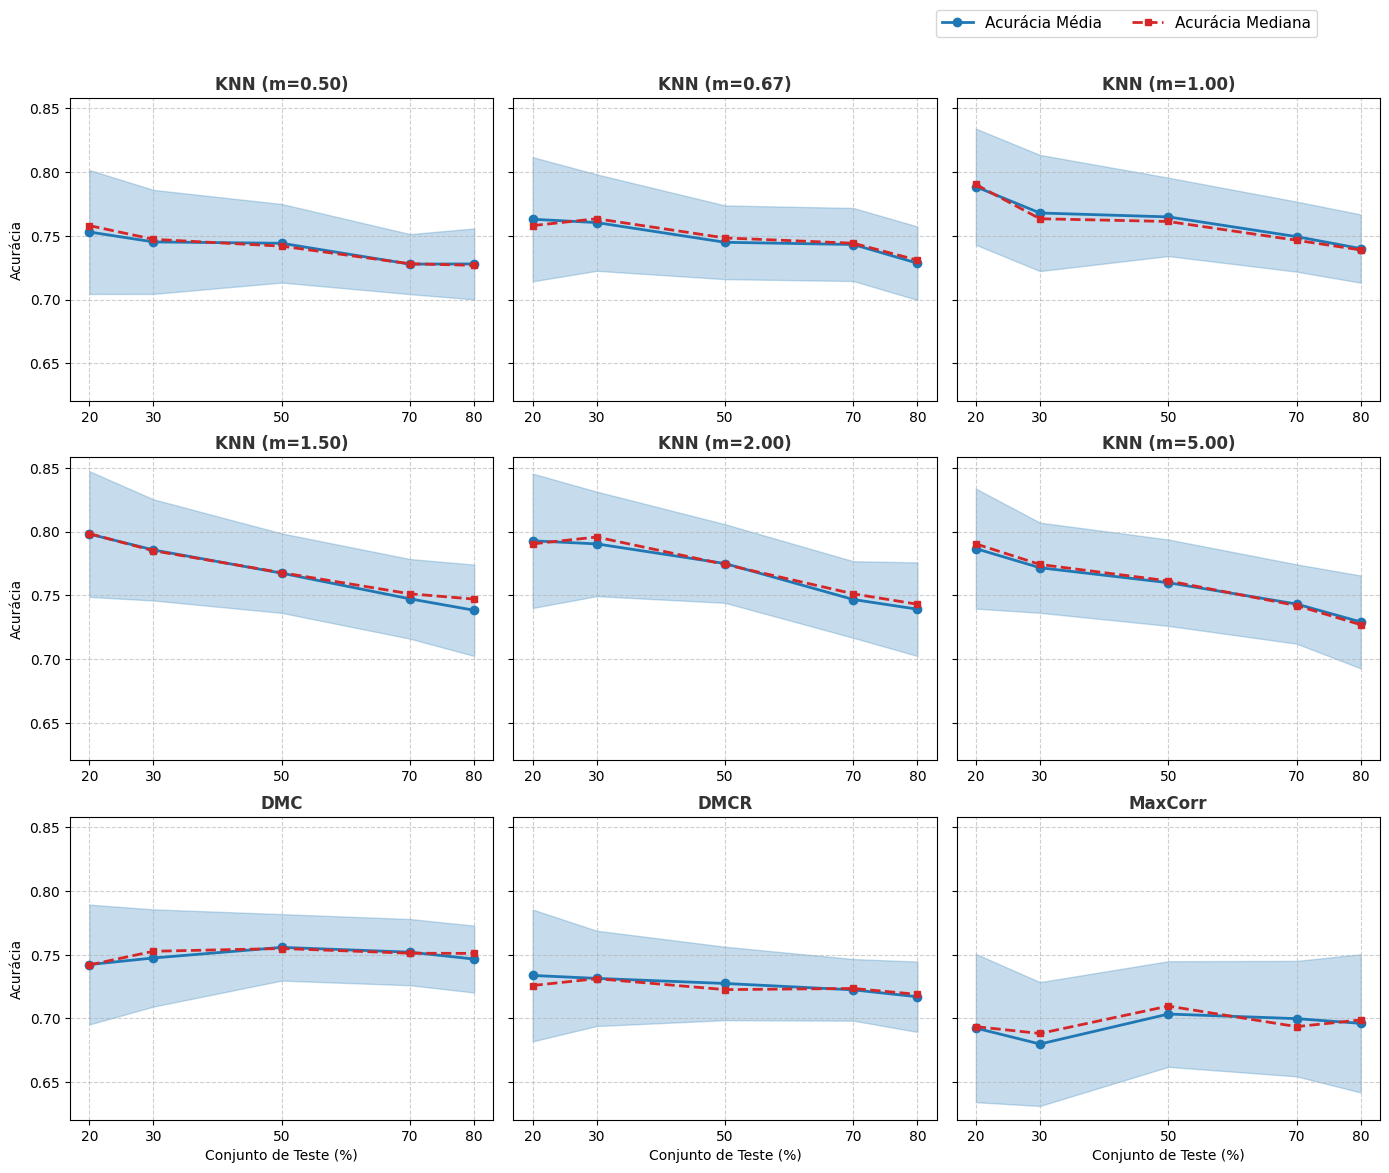

In [126]:
plotar_grid_acuracias_std_mediana(resultados_por_modelo)

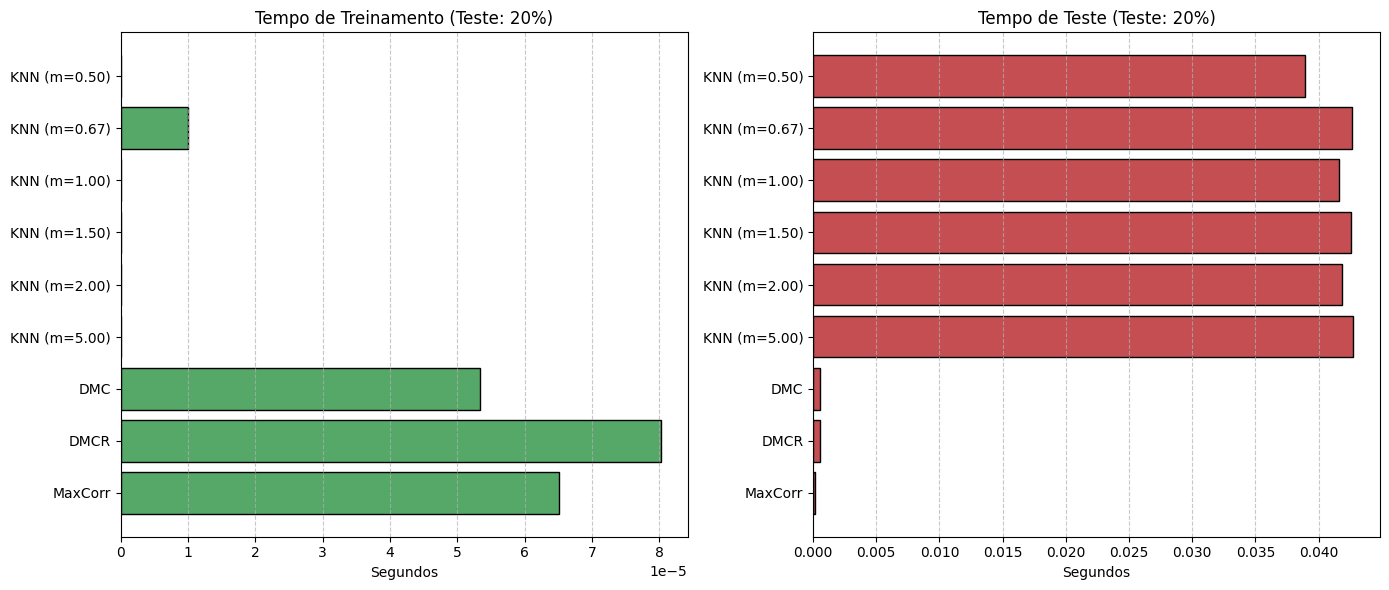

In [115]:
plotar_tempos_condensados(resultados_por_modelo, test_size_foco=0.2)

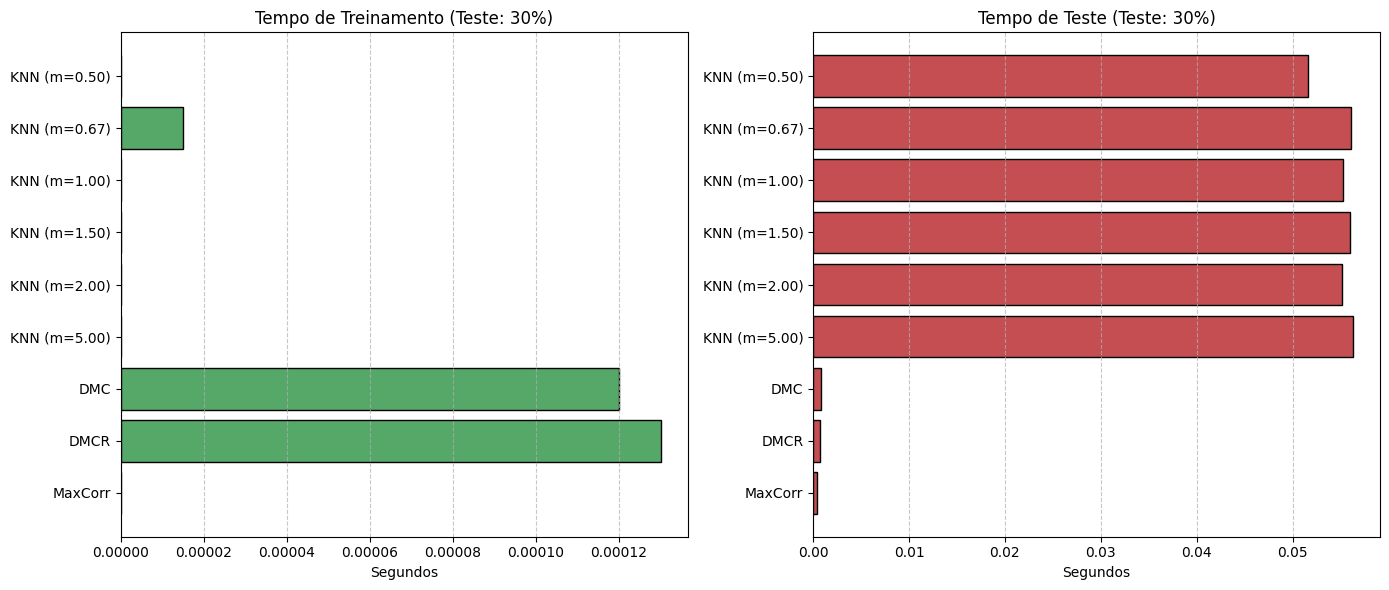

In [116]:
plotar_tempos_condensados(resultados_por_modelo, test_size_foco=0.3)

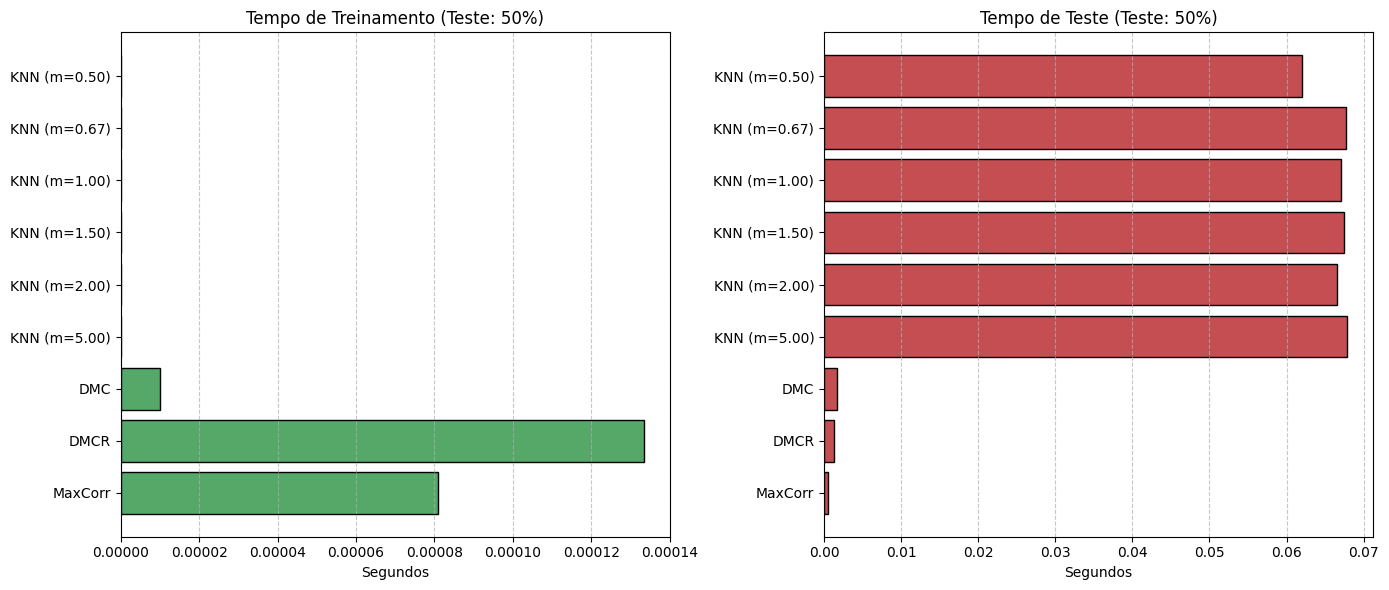

In [117]:
plotar_tempos_condensados(resultados_por_modelo, test_size_foco=0.5)

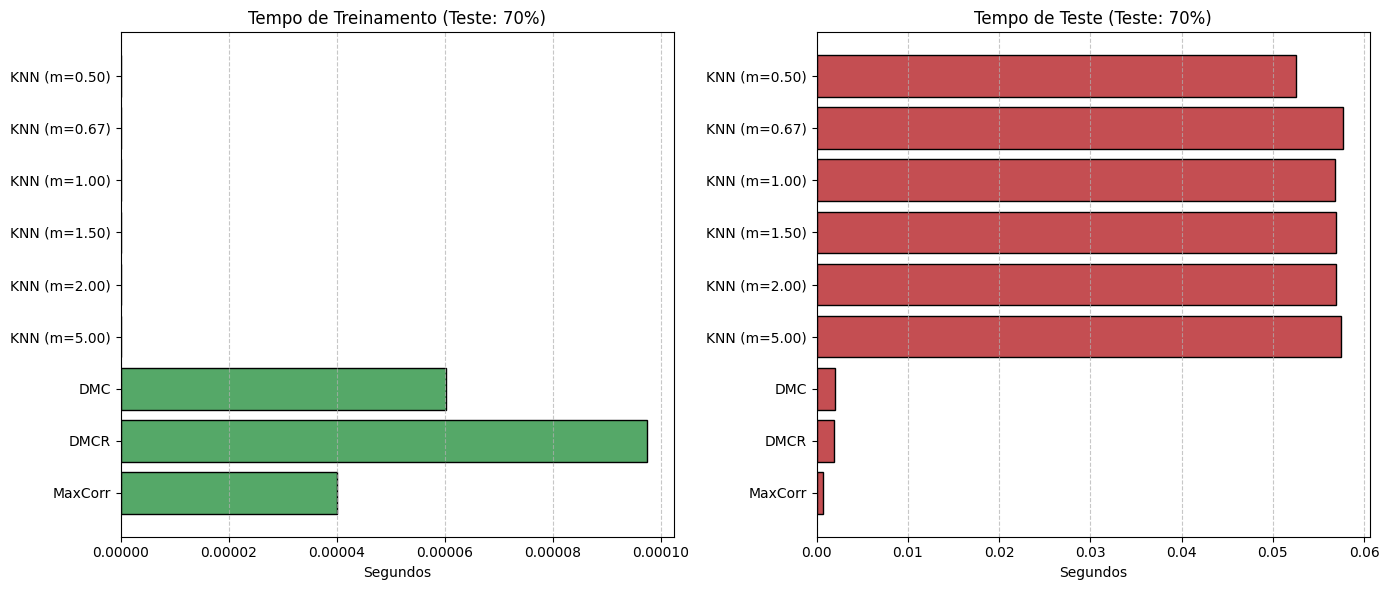

In [118]:
plotar_tempos_condensados(resultados_por_modelo, test_size_foco=0.7)

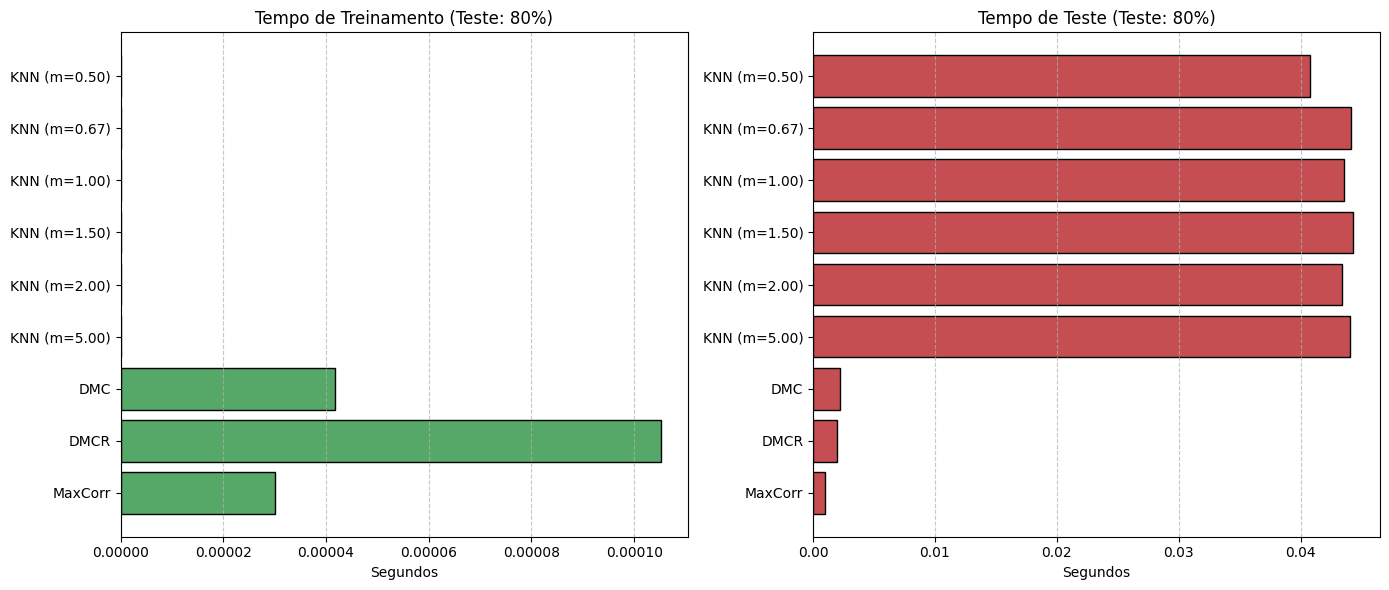

In [119]:
plotar_tempos_condensados(resultados_por_modelo, test_size_foco=0.8)

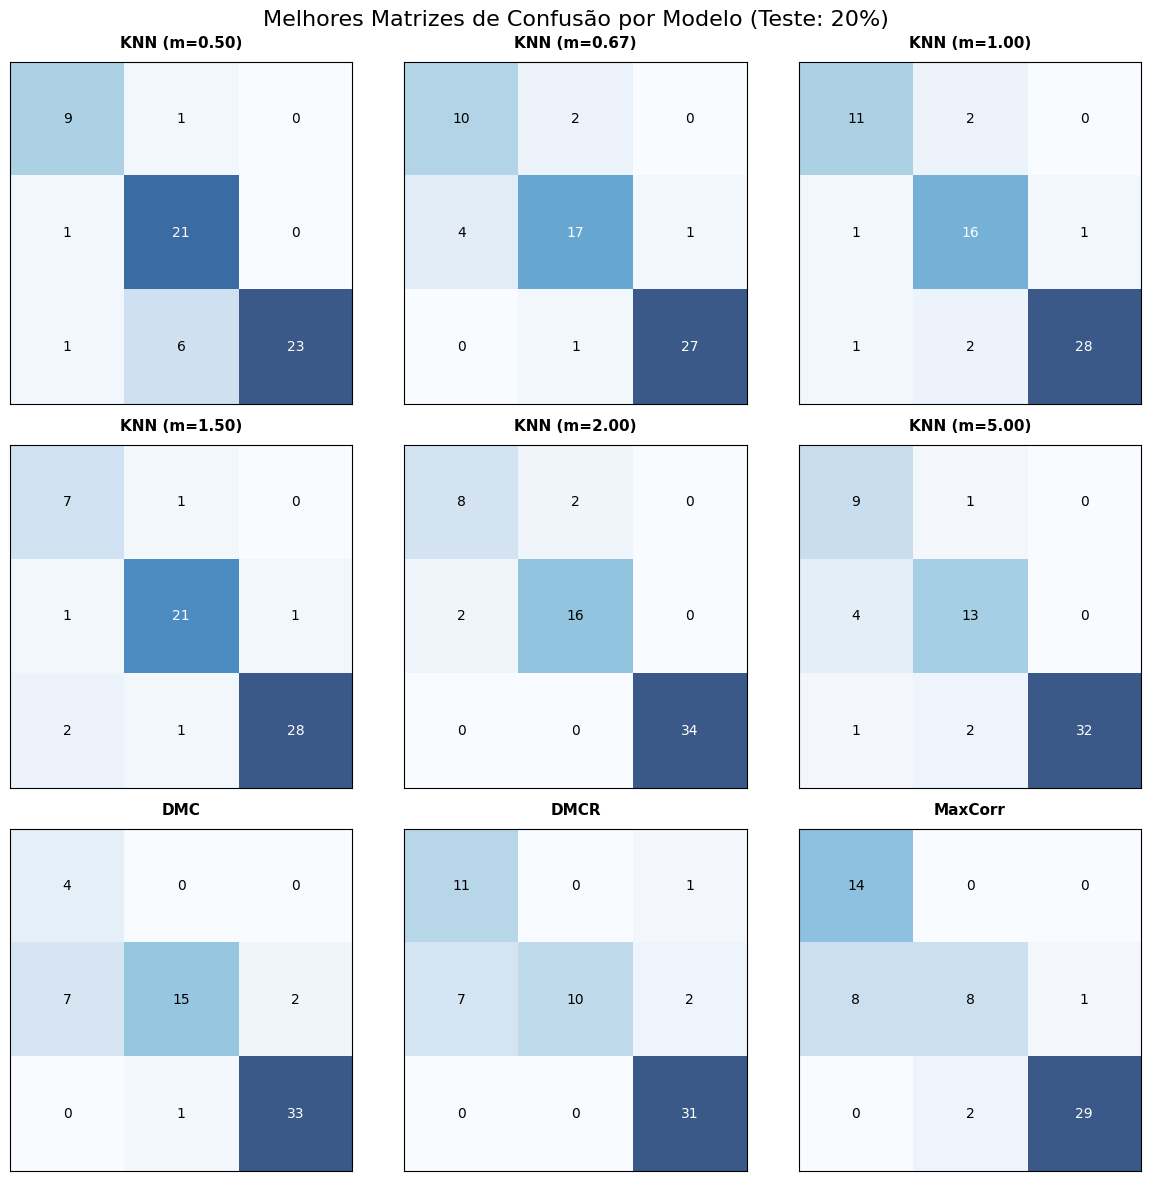

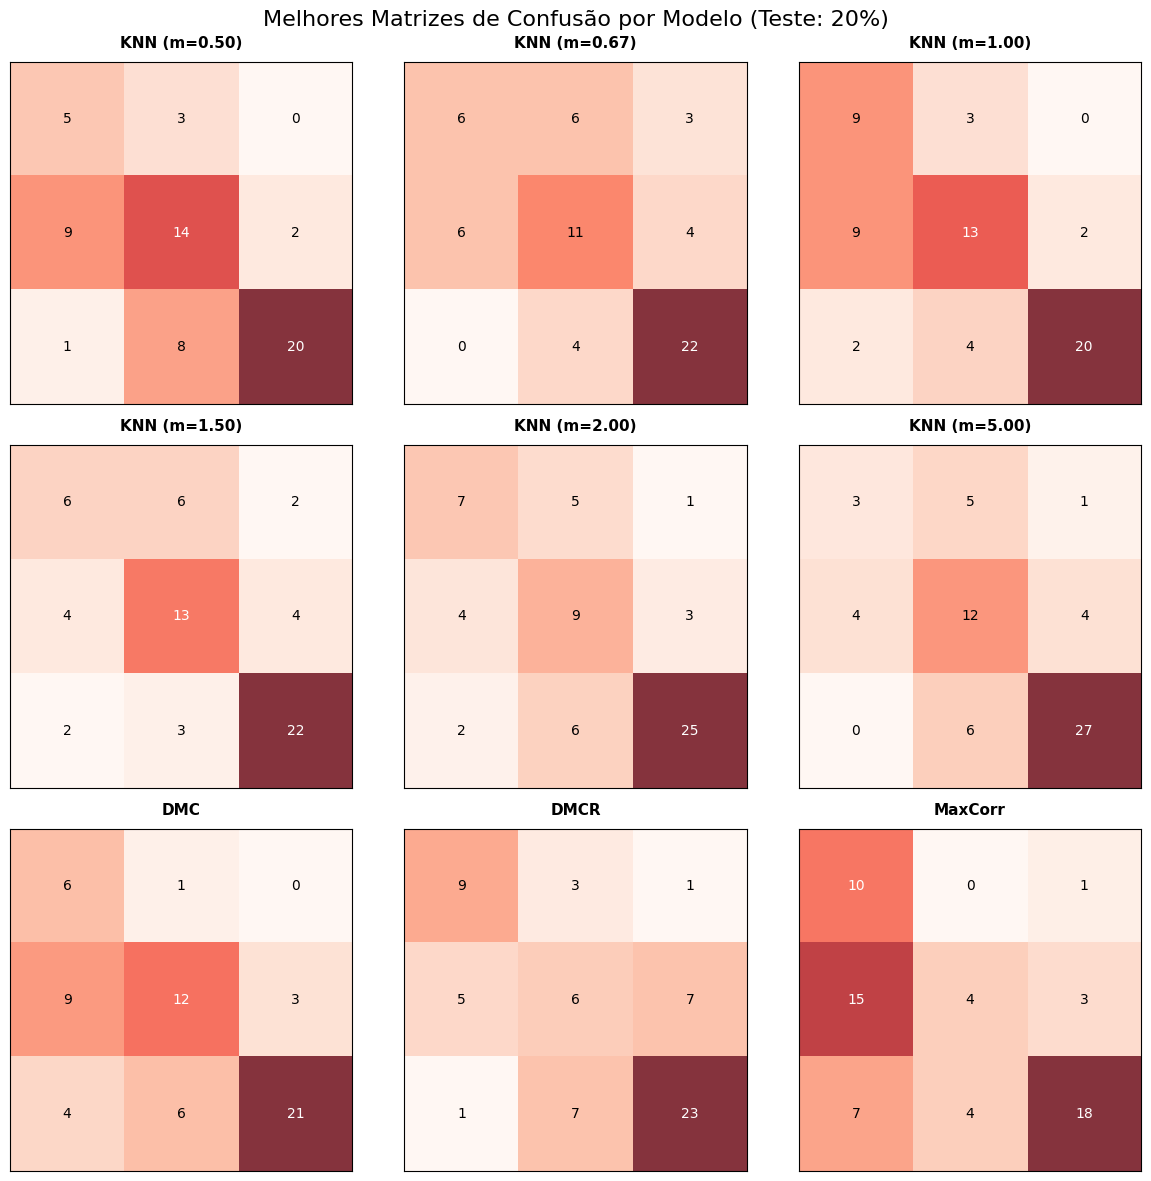

In [120]:
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.2 ,tipo="melhor_cm")
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.2 ,tipo="pior_cm")

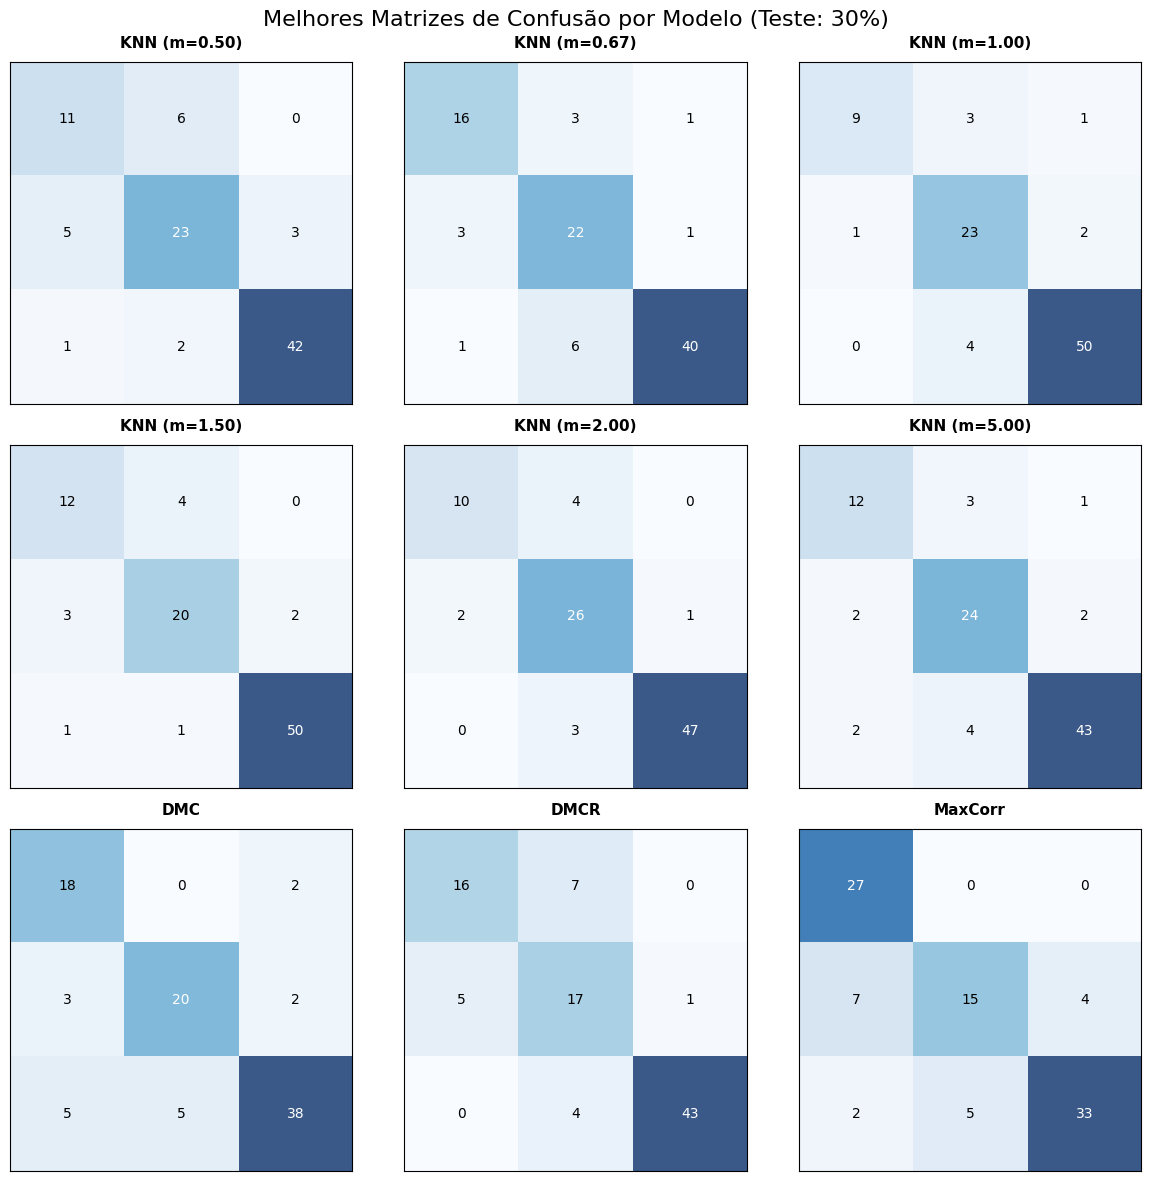

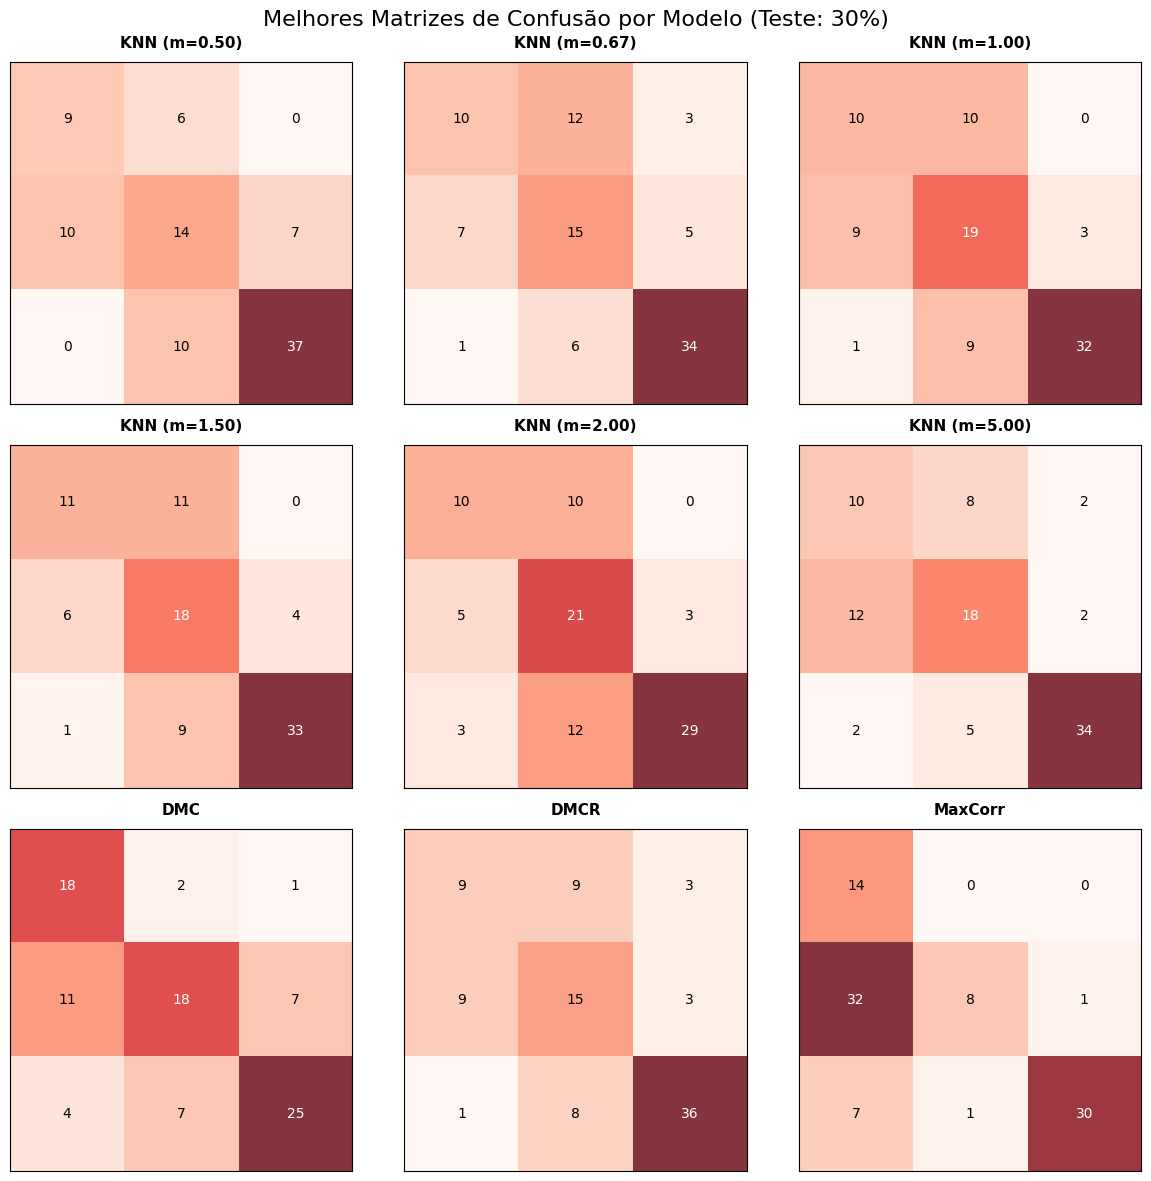

In [121]:
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.3 ,tipo="melhor_cm")
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.3 ,tipo="pior_cm")

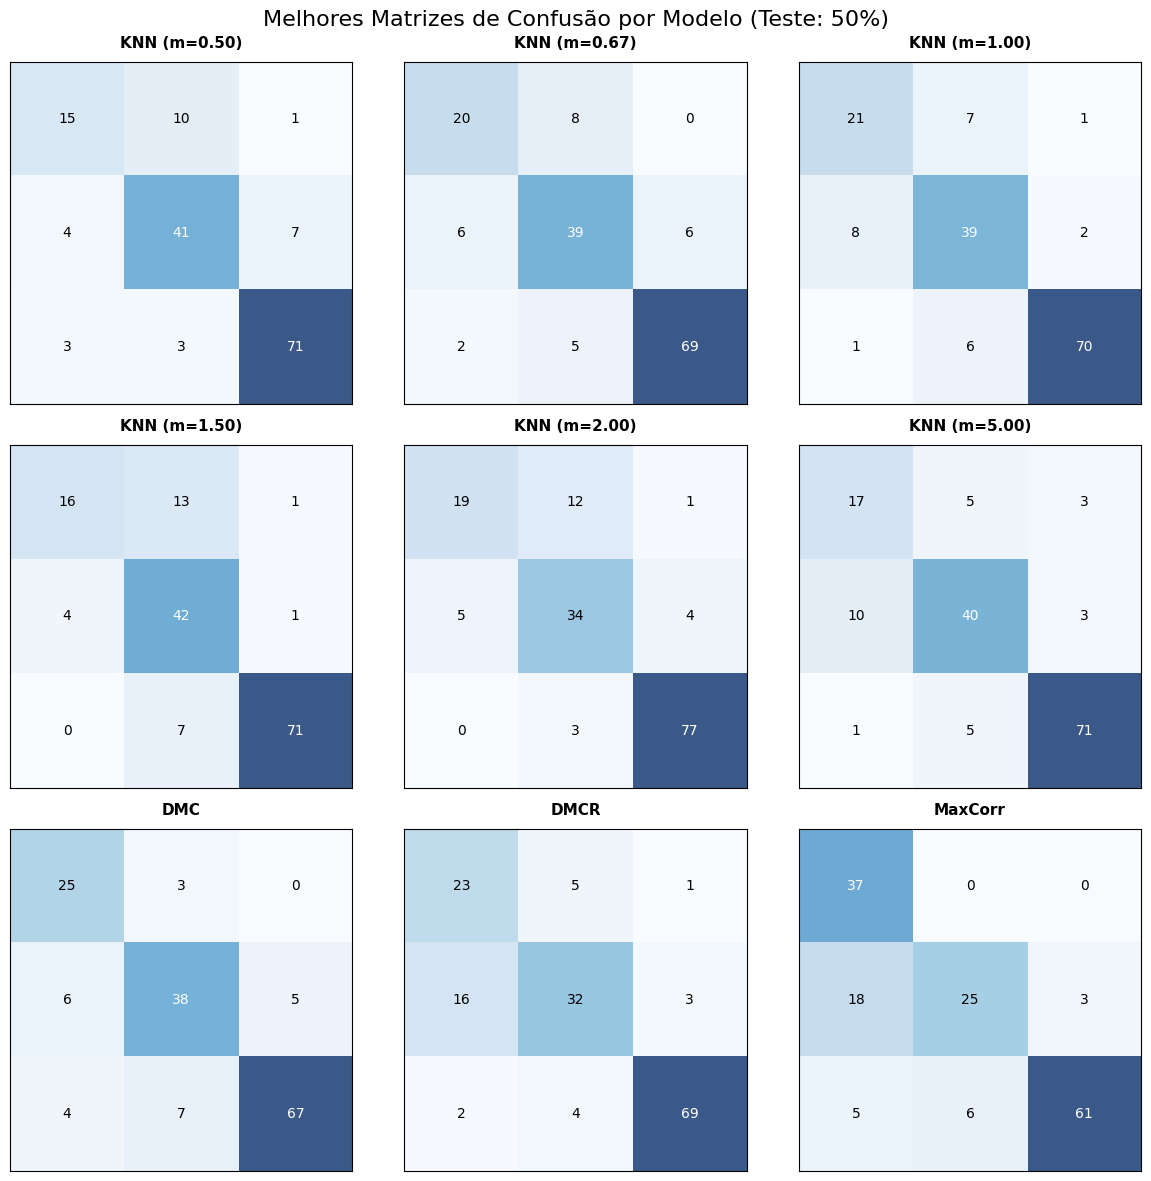

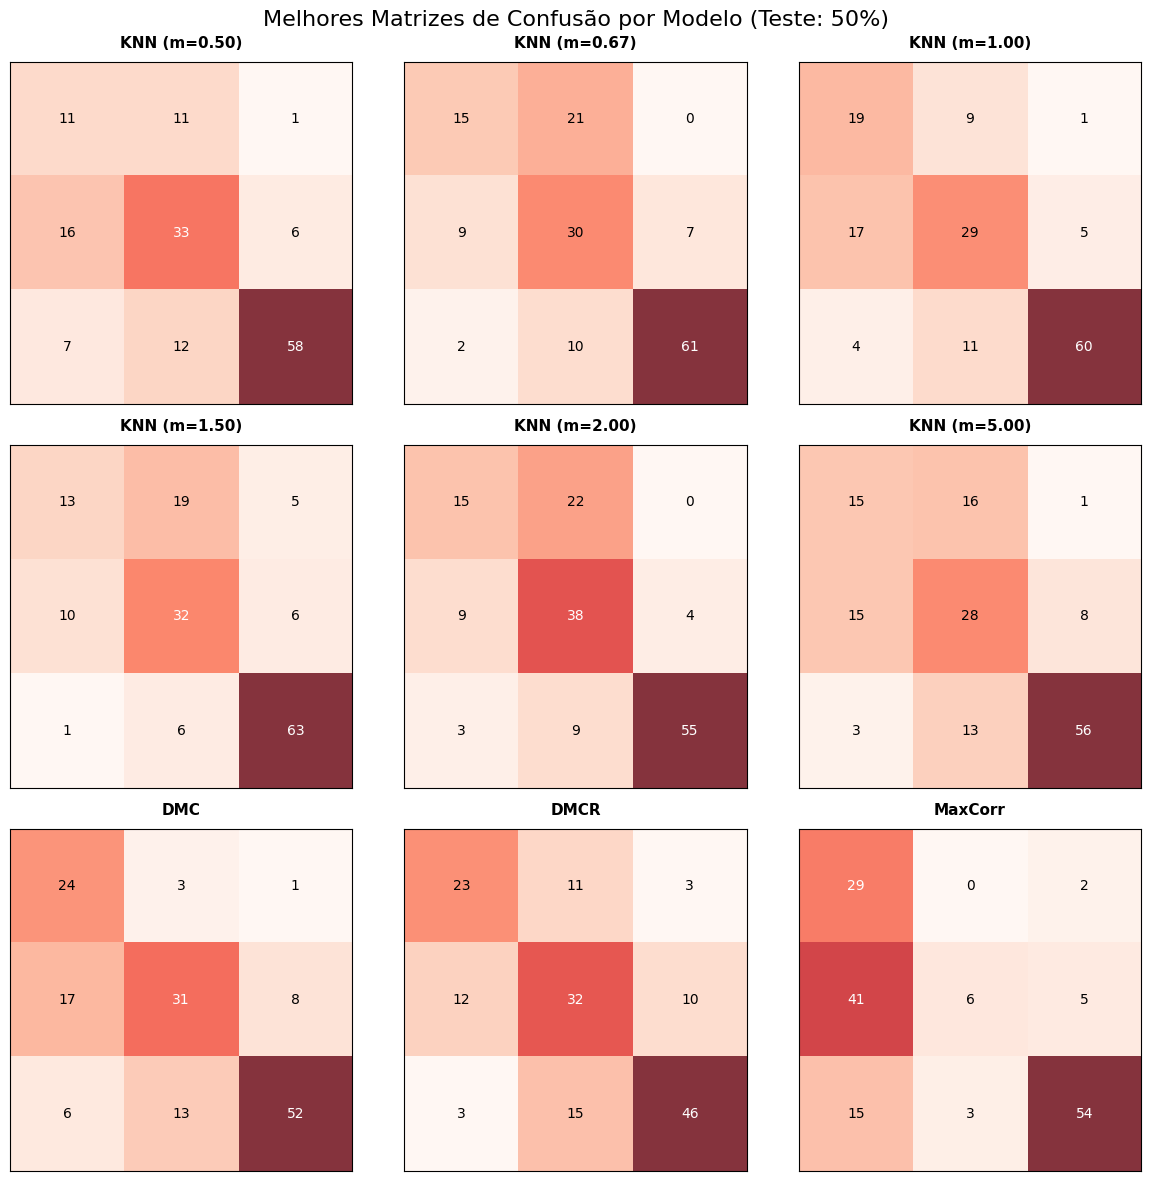

In [122]:
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.5 ,tipo="melhor_cm")
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.5 ,tipo="pior_cm")

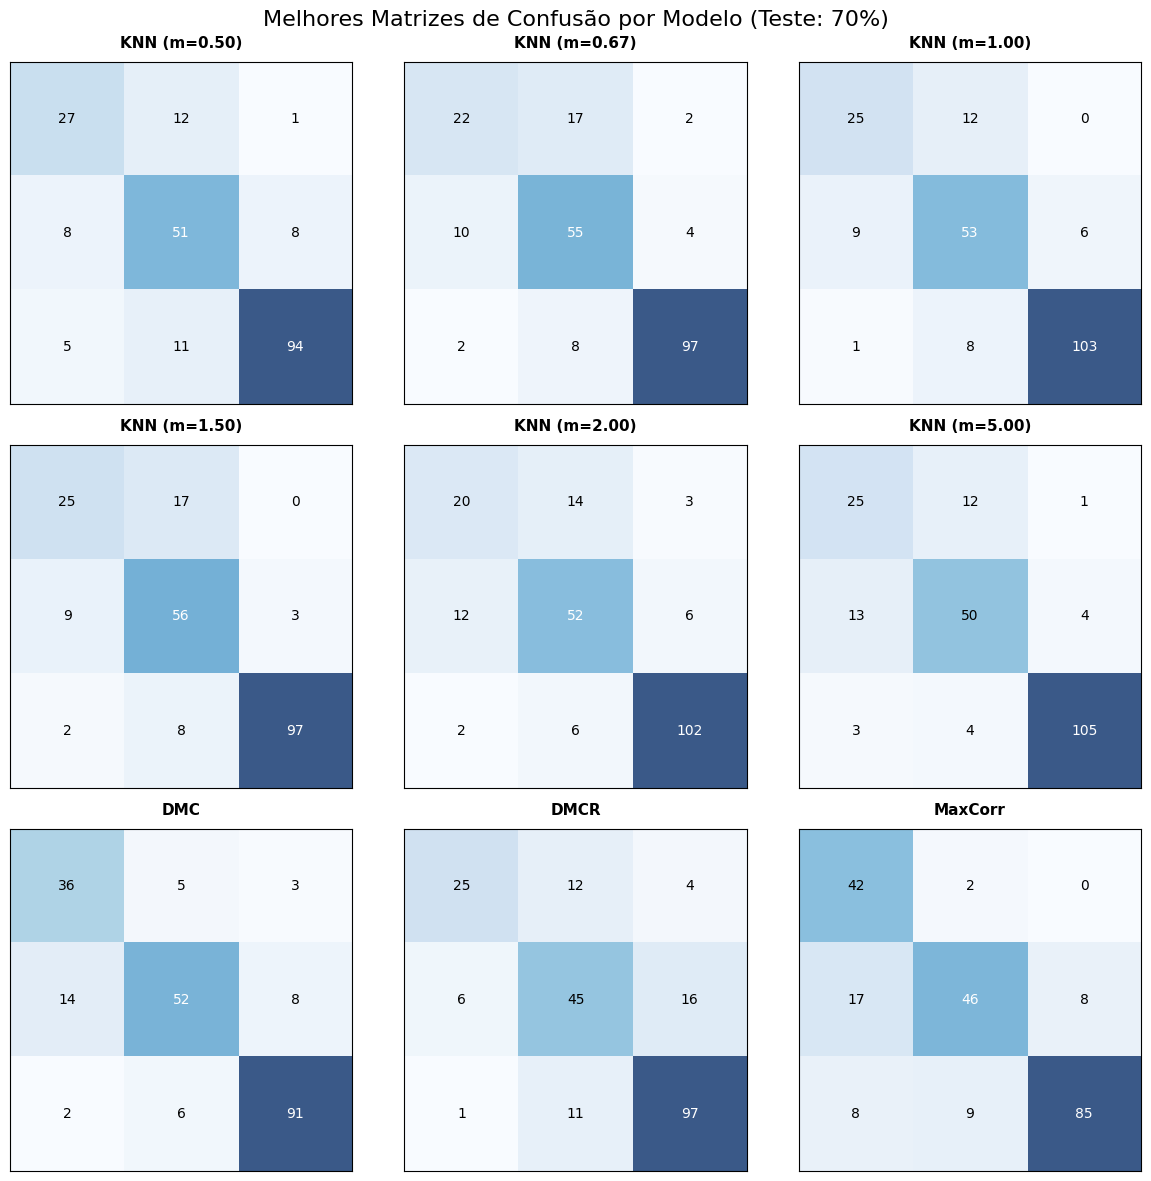

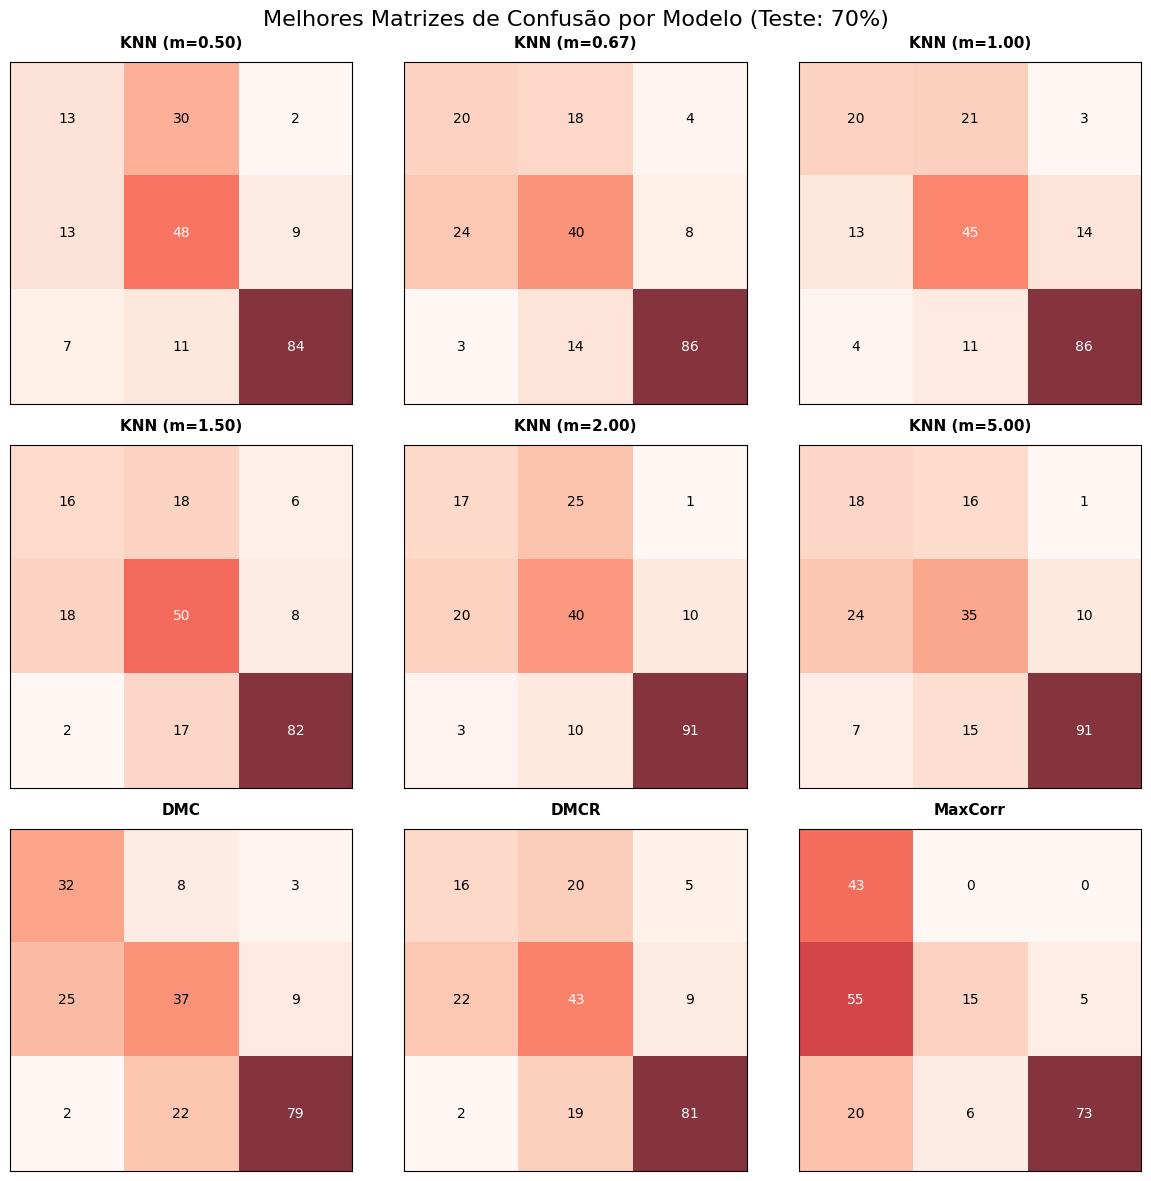

In [123]:
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.7 ,tipo="melhor_cm")
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.7 ,tipo="pior_cm")

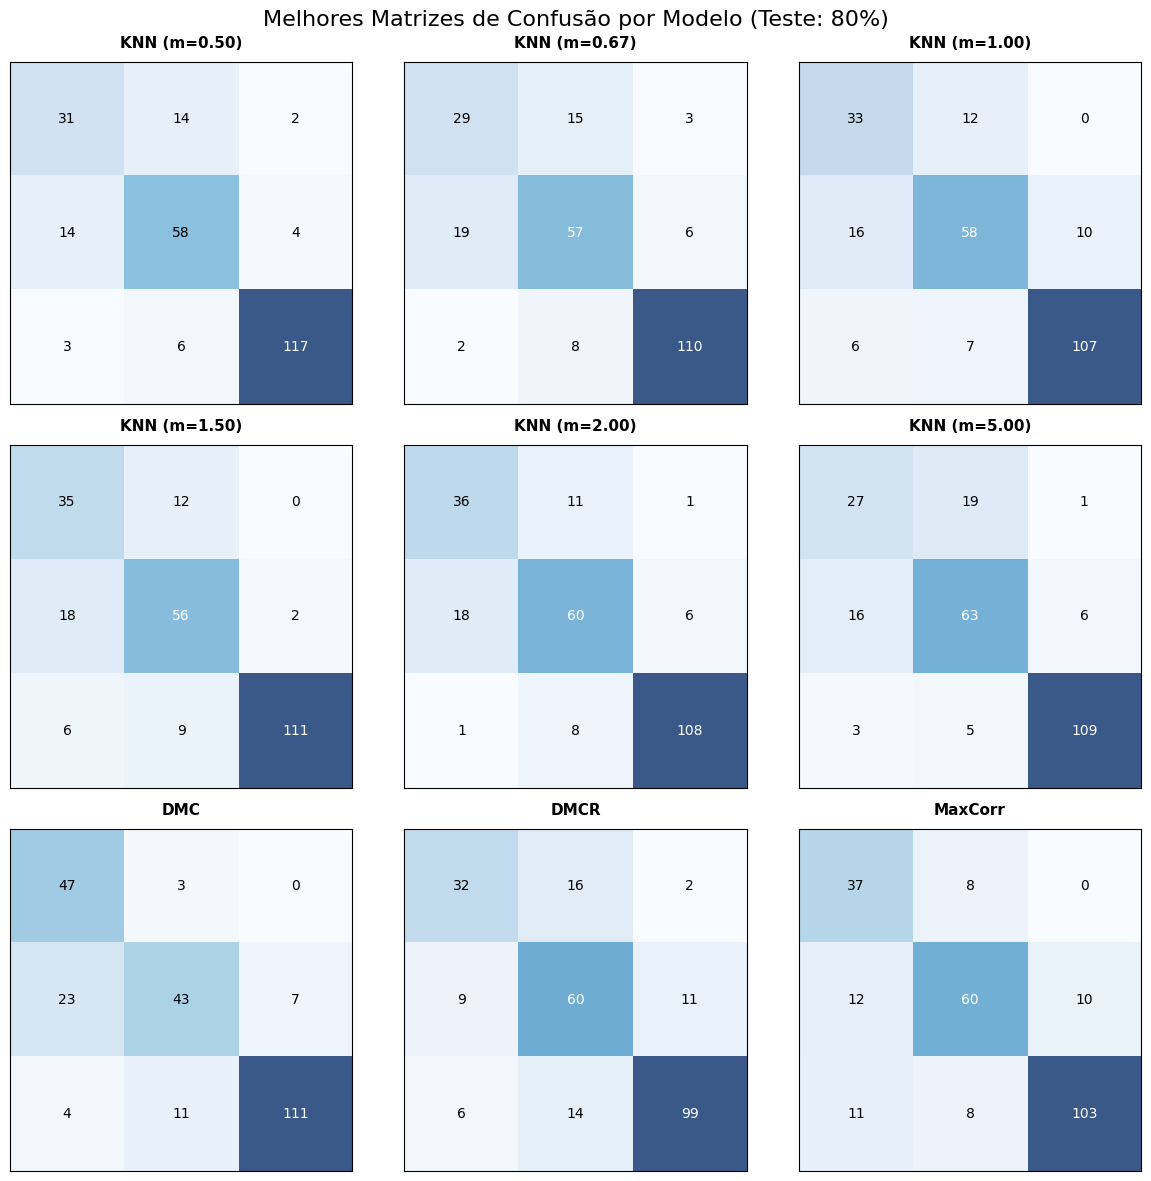

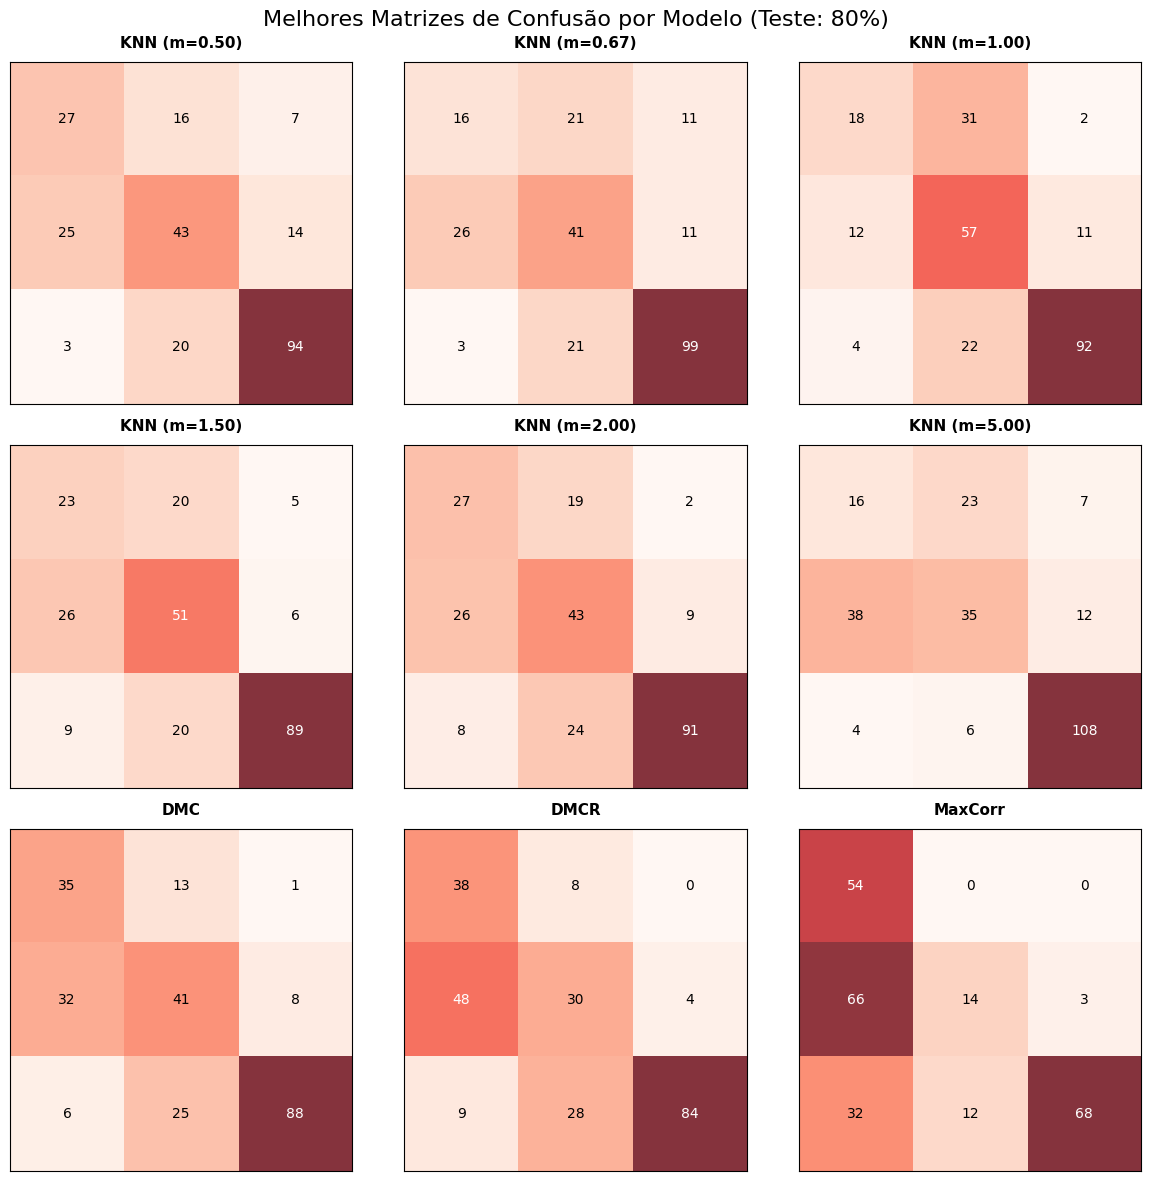

In [124]:
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.8 ,tipo="melhor_cm")
plotar_grid_matrizes(resultados_por_modelo, test_size_foco=0.8 ,tipo="pior_cm")